# Usage example of the refactored program

## Some basic examples of the syntax and how to use the software

In [1]:
import qcodes as qc
from qcodes.instrument import Instrument, ManualParameter
from qcodes.station import Station

from metainstruments.ZCUStation import ZCU216Station
from metainstruments.ZCUMetainstrument import ZCU216Metainstrument
from measurements.Protocols import Protocol
from measurements.T1Protocol import T1Protocol
from measurements.PulseProbeSpectroscopyProtocol import PulseProbeSpectroscopyProtocol
from measurements.NDSweepProtocol import NDSweepProtocol
from qick import *


import numpy as np
import matplotlib.pyplot as plt

### The setup revolves around defining a qcodes station that contains instruments (zcu metainstrument, measurement protocols, and DAC/ADC channels etc.), and handles the initialization and output handling of measurement data

In [2]:
#Initializing the station and the database
qc.initialise_or_create_database_at("./experiment-data/zcu_test_data.db")
station = ZCU216Station()

In [3]:
#Initializing the experiment
experiment = qc.load_or_create_experiment(
                experiment_name="ZCU_QICK_QCODES_TEST",
                sample_name="None")

### Access to QickSoc

In [4]:
# The following command can be used to configure to see what qick channel corresponds to what physical port
# station.troubleshoot returns the QickSock object
print(station.troubleshoot())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.211
	Firmware timestamp: Mon Aug 21 11:09:34 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

### Qick channels, that correspond to physical DACs and ADCs through their channel number are defined as instruments contained in the station. The channels have specific parameters that will be utilized by a protocol to perform a measurement 

In [5]:
#At the time of writing, we have connected DACs 2_231 and 0_231 to the adc's and oscilloscopes, these have  
#qick channels 6 and 4. The physically connected ADC channel is 0_226. Thus, our configuration will be:
station.add_DAC_channel(name="Probe", channel=6)
station.add_DAC_channel(name="Readout", channel=4)
station.add_ADC_channel(name="ADC", channel=0)

In [6]:
station.ADC.print_readable_snapshot()


ADC:
	parameter value
--------------------------------------------------------------------------------
IDN     :	{'vendor': None, 'model': 'ADC', 'serial': None, 'firmware': None} 
channel :	0 


In [7]:
station.Probe.print_readable_snapshot()

Probe:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': None, 'model': 'Probe', 'serial': None, 'firmware':...
channel      :	6 
nqz          :	1 
pulse_freq   :	500 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)


### Protocols, that handle specific qick programs with specific DAC/ADC configuration requirements, are also instruments in the station that are passed to measurement methods. The protocols have measurement specific parameters.  

In [8]:
station.add_protocol(NDSweepProtocol(name='vna'))

<NDSweepProtocol: vna>

In [9]:
station.vna.print_readable_snapshot()
print()
print("adc_trig_offset means:", station.vna.adc_trig_offset.label)

vna:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': None, 'model': 'vna', 'serial': None, 'firmware'...
adc_trig_offset :	100 (Clock ticks)
readout_length  :	5 (us)
relax_delay     :	0.1 (us)
reps            :	400 

adc_trig_offset means: Delay between sending probe pulse and ADC initialization


### Given a protocol, and protocol specific channels, you can run a measurement as follows

In [10]:
# Iterate the frequency of the probe pulse from 1000 to 1100 MHz, with 10 iteration points. The probe
# channel is defined in the dac_channels as 'probe', and the adc channel is defined in adc_channels. The
# protocol you defined and configured is set as the protocol.

vna_run_id = station.measure_iq(params_and_values = {  station.Probe.pulse_freq: [1000, 1100, 10]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Probe},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1500. 


### access to the measurement result

In [11]:
dataset = qc.load_by_id(vna_run_id).to_xarray_dataset()
dataset

/usr/local/share/pynq-venv/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<xarray.Dataset>
Dimensions:           (Probe_pulse_freq: 10)
Coordinates:
  * Probe_pulse_freq  (Probe_pulse_freq) float64 100.0 644.4 ... 4.456e+03 5e+03
Data variables:
    avg_i             (Probe_pulse_freq) float64 -0.001646 -0.3503 ... 5.726
    avg_q             (Probe_pulse_freq) float64 -0.001213 0.4495 ... 42.58
Attributes: (12/14)
    ds_name:                  results
    sample_name:              None
    exp_name:                 ZCU_QICK_QCODES_TEST
    snapshot:                 {"station": {"instruments": {"zcu": {"functions...
    guid:                     aaaaaaaa-0000-0000-0000-018b496eddff
    run_timestamp:            2023-10-19 19:34:44
    ...                       ...
    captured_counter:         15
    run_id:                   1500
    run_description:          {"version": 3, "interdependencies": {"paramspec...
    parent_dataset_links:     []
    run_timestamp_raw:        1697744084.7081962
    completed_timestamp_raw:  1697744084.8455236

## Example, finding the resonant frequency of the cavity

In [12]:
station.Probe.pulse_gain(10000)
station.Probe.nqz(2)
station.vna.readout_length(1.5)
station.Probe.pulse_length(1)
station.vna.reps(500)
station.print_configuration()

Station configuration:


zcu:
	parameter value
--------------------------------------------------------------------------------
IDN :	{'vendor': None, 'model': 'zcu', 'serial': None, 'firmware': None} 

Probe:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': None, 'model': 'Probe', 'serial': None, 'firmware':...
channel      :	6 
nqz          :	2 
pulse_freq   :	500 (MHz)
pulse_gain   :	10000 (DAC units)
pulse_length :	1 (us)
pulse_phase  :	0 (deg)

Readout:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': None, 'model': 'Readout', 'serial': None, 'firmware...
channel      :	4 
nqz          :	1 
pulse_freq   :	500 (MHz)
pulse_gain   :	5000 (DAC units)
pulse_length :	10 (us)
pulse_phase  :	0 (deg)

ADC:
	parameter value
--------------------------------------------------------------------------------
IDN     :	{'vendor': None, 'model': 

In [27]:
vna_run_id = station.measure_iq(params_and_values = {  station.Probe.pulse_freq: [100, 8000, 10000]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Probe},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1489. 


In [15]:
# Helper function
def oneD_plot_amplitude(dataset):
    for coordinate in dataset.coords:
        plt.plot(dataset[coordinate], abs(dataset.avg_q +1j*dataset.avg_i) )
        plt.ylabel('Amplitude')
        plt.xlabel(dataset.coords[coordinate].long_name + f' ({dataset.coords[coordinate].unit})')
    pass

### Without cavity

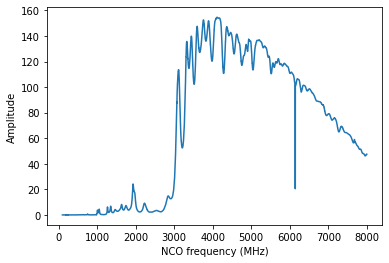

In [24]:
#Looks this way since we are in the 5-6ghz block
oneD_plot_amplitude(qc.load_by_id(1489).to_xarray_dataset())

### With cavity

In [25]:
vna_run_id = station.measure_iq(params_and_values = {  station.Probe.pulse_freq: [100, 8000, 1000]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Probe},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1497. 


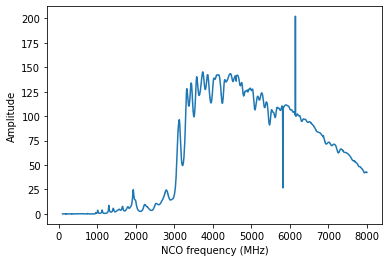

In [29]:
oneD_plot_amplitude(qc.load_by_id(1494).to_xarray_dataset())

### Some strange resonance around 6.1 GHz, but the resonant frequency should be the peak not found in the previous measurement. Taking a closer look

In [30]:
vna_run_id = station.measure_iq(params_and_values = {  station.Probe.pulse_freq: [5500, 6000, 1000]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Probe},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1498. 


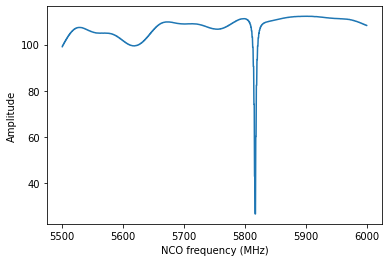

In [32]:
oneD_plot_amplitude(qc.load_by_id(vna_run_id).to_xarray_dataset())

In [19]:
vna_run_id = station.measure_iq(params_and_values = {  station.Probe.pulse_freq: [5810, 5825, 1000]}, 
                         protocol = station.vna, 
                         dac_channels = {'probe': station.Probe},
                         adc_channels = {'adc' : station.ADC},
                         experiment = experiment)

Starting experimental run with id: 1503. 


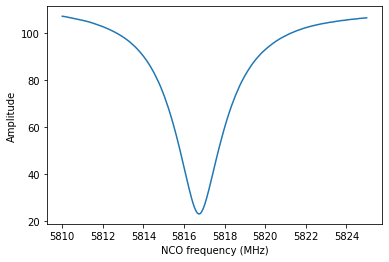

In [20]:
oneD_plot_amplitude(qc.load_by_id(vna_run_id).to_xarray_dataset())

## So the resonant frequency is around 5816.5 MHz